<a href="https://colab.research.google.com/github/Royal4224/ENM_5320/blob/main/Code/cnn_stencil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coding Lecture - Building an architecture for nonlinear stencil learning

## First, modifying the previous code

To start with we will modify the code we played with in the previous homework to build up nonlinear stencils. I've copied and pasted below:

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define the model
class FiniteDifferenceOperator(nn.Module):
    def __init__(self,Nleft,Nright):
        super(FiniteDifferenceOperator, self).__init__()
        # Number of total nodes in finite difference stencils
        self.Nstencil = Nleft + Nright + 1
        self.Nleft = Nleft
        self.Nright = Nright

        # Initialize with random coefficients
        self.stencil = torch.nn.Parameter(torch.randn(self.Nstencil))
        # self.stencil = torch.from_numpy((0.5/dx)*np.array([1,0,-1]))


    def forward(self, x):
        # Apply the finite difference stencil to the gridfunction x, assuming periodic BC
        N_nodes = x.shape[0]
        f_out = torch.zeros_like(x)
        for i in range(N_nodes):
          for jj in range(self.Nstencil):
            j = jj - self.Nleft
            j_withbc = (i+j)%(N_nodes-1)
            f_out[i] += self.stencil[jj]*x[j_withbc]

        return f_out

I'm going to modify the forward pass so that it functions identically, but uses syntax that will be better for nonlinear terms.

In [ ]:
# Define the model
class FiniteDifferenceOperator(nn.Module):
    def __init__(self,Nleft,Nright,num_layers, hidden_dim):
        super(FiniteDifferenceOperator, self).__init__()
        # Number of total nodes in finite difference stencils
        self.Nstencil = Nleft + Nright + 1
        self.Nleft = Nleft
        self.Nright = Nright
        self.stencil = torch.nn.Parameter(torch.randn(self.Nstencil))
    def forward(self, x, h):
        # Apply the finite difference stencil to the gridfunction x, assuming periodic BC
        N_nodes = x.shape[0]
        f_out = torch.zeros_like(x)
        for i in range(N_nodes):
          # Wrap indices periodically using the modulo operator (%)
          indices = [(i + j - self.Nleft) % (N_nodes-1) for j in range(self.Nstencil)]

          # Grab solution at indices
          xstencil = x[indices]

          # Apply learned stencil to xstencil
          f_out[i] = torch.sum(self.stencil * xstencil)

        # Return stencil applied to current state consisting of nonlinearity and stabilizing diffusion
        return f_out

Next we will take that code and modify it so that we can enhance model stability via artificial viscosity. Remember from our analysis in class that we showed a nonlinear problem of the form
$$\mathbf{A} x + \epsilon \mathcal{N}[x] = f$$
has a solution if $A$ is invertible and $\mathcal{N}$ is Lipschitz, and the operator norm of $A$ is large relative to the Lipschitz constant of $\mathcal{N}$.

Motivated by this, we will first add a hardcoded diffusion component to the stencil:
$$\mathcal{D} u = D_+ D_- u = \frac{1}{h^2}\left[ u_{j+1} - 2 u_j + u_{j-1}\right]$$

In [ ]:
# Define the model
class FiniteDifferenceOperator(nn.Module):
    def __init__(self,Nleft,Nright,num_layers, hidden_dim):
        super(FiniteDifferenceOperator, self).__init__()
        # Number of total nodes in finite difference stencils
        self.Nstencil = Nleft + Nright + 1
        self.Nleft = Nleft
        self.Nright = Nright

        # The learnable part of the stencil
        self.stencil = torch.nn.Parameter(torch.randn(self.Nstencil))
        # The diffusion parameter. To enforce positivity, we evolve the log of the magnitude
        self.logstabilizer = torch.nn.Parameter(torch.tensor(0.0, dtype=torch.float64))


    def forward(self, x, h):
        # Apply the finite difference stencil to the gridfunction x, assuming periodic BC
        N_nodes = x.shape[0]
        f_out = torch.zeros_like(x)
        for i in range(N_nodes):
          # Wrap indices periodically using the modulo operator (%)
          indices = [(i + j - self.Nleft) % (N_nodes-1) for j in range(self.Nstencil)]

          # Grab solution at indices
          xstencil = x[indices]

          # Hard coded diffusion operator
          D2x = h**(-2)*(x[(i-1)%(N_nodes-1)] - 2*x[i] + x[(i+1)%(N_nodes-1)])

          # Apply learned stencil to xstencil, including the viscosity term
          f_out[i] = torch.sum(self.stencil * xstencil) + torch.exp(self.logstabilizer)*D2x

        # Return stencil applied to current state consisting of nonlinearity and stabilizing diffusion
        return f_out

Finally, we can modify the stencil so that it can depend nonlinearly upon the solutions nodal values.

In [ ]:
# Define the model
class FiniteDifferenceOperator(nn.Module):
    def __init__(self,Nleft,Nright,num_layers, hidden_dim):
        super(FiniteDifferenceOperator, self).__init__()
        # Number of total nodes in finite difference stencils
        self.Nstencil = Nleft + Nright + 1
        self.Nleft = Nleft
        self.Nright = Nright

        # The learnable part of the stencil
        self.stencil = torch.nn.Parameter(torch.randn(self.Nstencil))
        # The diffusion parameter. To enforce positivity, we evolve the log of the magnitude
        self.logstabilizer = torch.nn.Parameter(torch.tensor(0.0, dtype=torch.float64))

        # Construct nonlinear network
        # -- The first layer scales up from Nstencil point to a hidden dimension (Input layer)
        # -- Next, hidden layers repeatedly alternate between linear transforms and nonlinear activations (Hidden layers)
        # -- Finally, a linear layer maps back down to Nstencil outputs
        # We'll use skip connections in the hidden layer to improve numerical stability

        layers = []

        # Input layer
        layers.append(nn.Linear(self.Nstencil, hidden_dim, dtype=torch.float64))
        layers.append(nn.Tanh())  # Activation function

        # Hidden layers
        # First make a list of hidden layers
        hiddenlayers = []
        for _ in range(num_layers):
            block = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim, dtype=torch.float64),
                nn.Tanh()
            )
            hiddenlayers.append(block)

        # Next apply skip connections
        class SkipConnectionBlock(nn.Module):
            def __init__(self, block):
                super(SkipConnectionBlock, self).__init__()
                self.block = block

            def forward(self, x):
                return x + self.block(x)

        skip_connection_layers = [SkipConnectionBlock(block) for block in hiddenlayers]
        hidden_layers = nn.Sequential(*skip_connection_layers)
        layers.extend(hidden_layers)

        # Output layer
        output_layer = nn.Linear(hidden_dim, self.Nstencil, dtype=torch.float64)
        output_layer.weight.data.fill_(0.0)  # Set weights to zero
        output_layer.bias.data.fill_(0.0)  # Set bias to zero (if any)
        layers.append(output_layer)

        self.nonlinear_network = nn.Sequential(*layers)

    def forward(self, x, h):
        # Apply the finite difference stencil to the gridfunction x, assuming periodic BC
        N_nodes = x.shape[0]
        f_out = torch.zeros_like(x)
        for i in range(N_nodes):
          # Wrap indices periodically using the modulo operator (%)
          indices = [(i + j - self.Nleft) % (N_nodes-1) for j in range(self.Nstencil)]

          # Grab solution at indices
          xstencil = x[indices]

          # Hard coded diffusion operator
          D2x = h**(-2)*(x[(i-1)%(N_nodes-1)] - 2*x[i] + x[(i+1)%(N_nodes-1)])

          # Apply learned stencil to xstencil, including the viscosity term
          f_out[i] = torch.sum(self.stencil * xstencil) + torch.exp(self.logstabilizer)*D2x

        # Return stencil applied to current state consisting of nonlinearity and stabilizing diffusion
        return f_out

In [ ]:
# Parameters
L = 2.0*np.pi  # Length of the domain
T = np.pi   # Total time
nx = 50  # Number of spatial points
nt = 100  # Number of time steps

# Discretization
dx = L / nx
dt = T / nt
x = torch.from_numpy(np.linspace(0, L, nx))
t = torch.from_numpy(np.linspace(0, T, nt))
Dx = FiniteDifferenceOperator(1,1,3,5)  # Finite difference operator w a neighbor on either side

# Define a single mode
def getData(x,k):
  return torch.sin(k*x)
def getLabel(x,k):
  return (getData(x-dt,k)-getData(x,k))/dt
  # return k*torch.cos(k*x)
  # return k*torch.sin(k*x/2.)

# Define the optimizer so that it optmizes over stencil parameters
optimizer = optim.Adam(Dx.parameters(), lr=0.01)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define the model (in our case, its y = A*x + b)
class FiniteDifferenceOperator(nn.Module):
    def __init__(self,Nleft,Nright,num_layers, hidden_dim):
        super(FiniteDifferenceOperator, self).__init__()
        # Number of total nodes in finite difference stencils
        self.Nstencil = Nleft + Nright + 1
        self.Nleft = Nleft
        self.Nright = Nright

        # Magnitude of diffusion operator to stabilize stencil
        self.logstabilizer = torch.nn.Parameter(torch.tensor(0.0, dtype=torch.float64))
        self.stabilizer = torch.exp(self.logstabilizer)
        self.advection = torch.nn.Parameter(torch.tensor(1.0, dtype=torch.float64))

        # Construct nonlinear network
        layers = []

        layers.append(nn.Linear(self.Nstencil, self.Nstencil, dtype=torch.float64))

        # # Input layer
        # layers.append(nn.Linear(self.Nstencil, hidden_dim, dtype=torch.float64))
        # layers.append(nn.Tanh())  # Activation function
        # # Hidden layers
        # for _ in range(num_layers - 2):
        #     layers.append(nn.Linear(hidden_dim, hidden_dim, dtype=torch.float64))
        #     layers.append(nn.Tanh())
        # # Output layer
        # output_layer = nn.Linear(hidden_dim, self.Nstencil, dtype=torch.float64)
        # output_layer.weight.data.fill_(0.0)  # Set weights to zero
        # output_layer.bias.data.fill_(0.0)  # Set bias to zero (if any)
        # layers.append(output_layer)

        self.nonlinear_network = nn.Sequential(*layers)

    def forward(self, x, h):
        # Apply the finite difference stencil to the gridfunction x, assuming periodic BC
        N_nodes = x.shape[0]
        f_out = torch.zeros_like(x)
        for i in range(N_nodes):
          # Wrap indices periodically using the modulo operator (%)
          indices = [(i + j - self.Nleft) % (N_nodes-1) for j in range(self.Nstencil)]

          # Grab solution at indices
          xstencil = x[indices]

          # # Apply MLP layer to stencil
          nonlinear_output = self.nonlinear_network(xstencil)

          # Compute d2dx2 = D_+*D_- x = h^{-2}*(ujm1 - 2 uj + ujp1)
          D2x = h**(-2)*(x[(i-1)%(N_nodes-1)] - 2*x[i] + x[(i+1)%(N_nodes-1)])
          D1x = -0.5*h**(-1)*(x[(i-1)%(N_nodes-1)] - x[(i+1)%(N_nodes-1)])
          # D1x = -h**(-1)*(x[i] - x[(i-1)%(N_nodes-1)])

          # Apply stencil
          # f_out[i] = torch.sum(nonlinear_output * xstencil) + h**2*torch.exp(self.stabilizer)*D2x
          f_out[i] = self.advection*D1x + h**2*torch.exp(self.logstabilizer)*D2x

        # Return stencil applied to current state consisting of nonlinearity and stabilizing diffusion
        return f_out

# Parameters
L = 2.0*np.pi  # Length of the domain
T = np.pi   # Total time
nx = 50  # Number of spatial points
nt = 100  # Number of time steps

# Discretization
dx = L / nx
dt = T / nt
x = torch.from_numpy(np.linspace(0, L, nx))
t = torch.from_numpy(np.linspace(0, T, nt))
Dx = FiniteDifferenceOperator(1,1,3,5)  # Finite difference operator w a neighbor on either side

# Define a single mode
def getData(x,k):
  return torch.sin(k*x)
def getLabel(x,k):
  return (getData(x-dt,k)-getData(x,k))/dt
  # return k*torch.cos(k*x)
  # return k*torch.sin(k*x/2.)

# Define the optimizer so that it optmizes over stencil parameters
optimizer = optim.Adam(Dx.parameters(), lr=0.01)

num_epochs = 1001
for epoch in range(num_epochs):

    # Clear gradients
    optimizer.zero_grad()

    # Pick a random wavenumber
    k = 1
    un = getData(x,k)
    Lun = getLabel(x,k)
    dudt_learned = Dx(un,dx)
    loss = torch.mean((Lun-dudt_learned)**2)

    # Backward pass and optimization
    loss.backward(retain_graph=True)
    optimizer.step()


    if epoch % 500 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss}')


Epoch [1/1001], Loss: 2.0757527929319943
Epoch [501/1001], Loss: 5.647829454853028e-05
Epoch [1001/1001], Loss: 2.221170243323496e-15


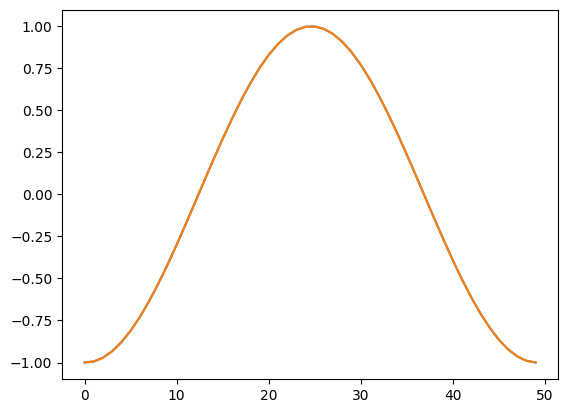

In [ ]:
sol = Dx(getData(x,1),dx)
plt.plot(sol.detach().numpy())
true = getLabel(x,1)
plt.plot(true.detach().numpy())


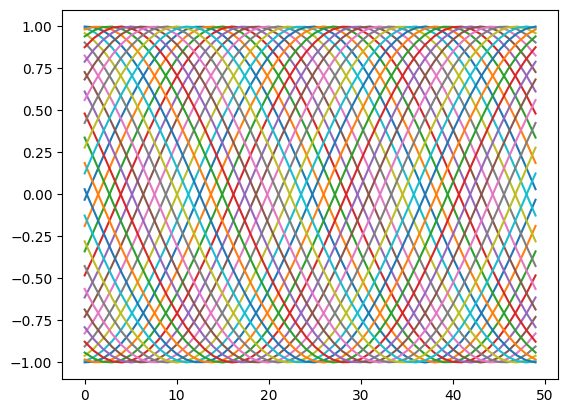

In [ ]:
uinit = np.sin(2 * np.pi * x / L)  # Initial condition
un = uinit

for m in range(200):
  un = un + dt*Dx(un,dx)
  if m%5==0:
    plt.plot(un.detach().numpy())

In [ ]:
#generate data consisting of the exact solution rolled out for nr rollout steps
nr = 5
udata = torch.sin(x.unsqueeze(0)-t[0:nr].unsqueeze(1))

# Define the optimizer so that it optmizes over stencil parameters
optimizer = optim.Adam(Dx.parameters(), lr=0.01)

num_epochs = 1000
for epoch in range(num_epochs):
    #
    # Clear gradients
    optimizer.zero_grad()

    # Rollout current solution
    usol = torch.zeros_like(udata)
    usol[0] = udata[0]
    for i in range(1,nr):
      usol[i,:] = usol[i-1,:] + dt*Dx(usol[i-1,:],dx)

    # Pick a random wavenumber

    loss = torch.mean((udata-usol)**2)

    # Backward pass and optimization
    loss.backward(retain_graph=True)
    optimizer.step()


    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss}')


Epoch [1/1000], Loss: 3.0800427551948933e-07
Epoch [11/1000], Loss: 9.974697776846864e-09
Epoch [21/1000], Loss: 2.1987299631880576e-08
Epoch [31/1000], Loss: 6.785945473906315e-09
Epoch [41/1000], Loss: 9.733864433886202e-10
Epoch [51/1000], Loss: 1.8519111849346674e-10
Epoch [61/1000], Loss: 1.1361210490045854e-10
Epoch [71/1000], Loss: 1.0513146789087129e-10
Epoch [81/1000], Loss: 5.7992369178545975e-11
Epoch [91/1000], Loss: 7.081798543281822e-12
Epoch [101/1000], Loss: 1.8014033874976115e-12
Epoch [111/1000], Loss: 2.5069306384962438e-12
Epoch [121/1000], Loss: 5.395550930006098e-14
Epoch [131/1000], Loss: 2.984216482583282e-13
Epoch [141/1000], Loss: 5.180798826110168e-14
Epoch [151/1000], Loss: 6.0504238195883656e-15
Epoch [161/1000], Loss: 1.4581709455407783e-14
Epoch [171/1000], Loss: 4.3187600105519904e-15
Epoch [181/1000], Loss: 3.8675036845083245e-16
Epoch [191/1000], Loss: 3.053238303512753e-19
Epoch [201/1000], Loss: 2.9303282039567395e-17
Epoch [211/1000], Loss: 2.394203

KeyboardInterrupt: 

In [ ]:
usol.shape

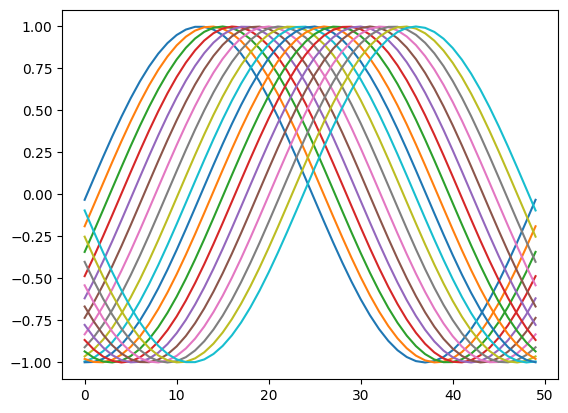

In [ ]:
uinit = np.sin(2 * np.pi * x / L)  # Initial condition
un = uinit

for m in range(100):
  un = un + dt*Dx(un,dx)
  if m%5==0:
    plt.plot(un.detach().numpy())

In [ ]:
un.min()

tensor(-0.9980, dtype=torch.float64, grad_fn=<MinBackward1>)

In [ ]:
print(Dx.advection.detach().numpy())
print(Dx.logstabilizer.detach().numpy())

-0.9924503544679651
-0.024313865245443978


See if we can learn a nonlinear operator - how about
$$L[u] = \partial_x u^2$$
which is representative of a nonlinear advection term like you would get in the Navier-Stokes equations.

For a given mode $u(x,t) = \sin(kx)$, we should recover
$$L[u] = \partial_x u^2 = 2 u \partial_x u = 2k \sin(kx) \cos(kx) = k \sin(\frac{kx}{2})$$